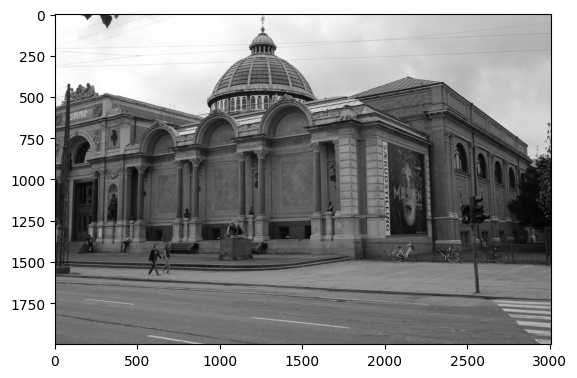

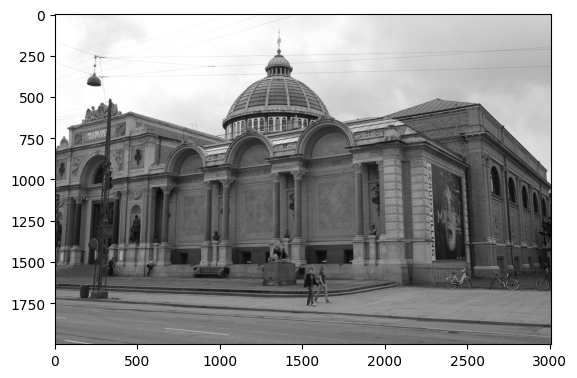

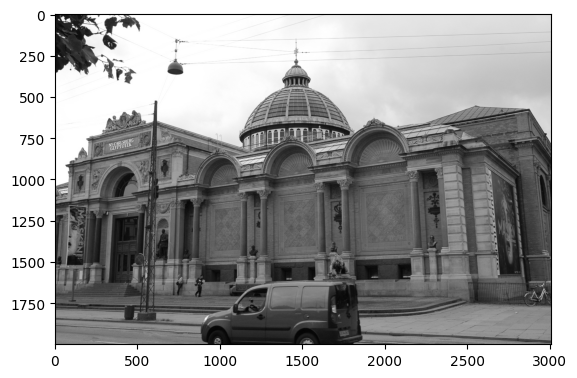

In [63]:
#ex 11 - 12
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt

K = np.loadtxt('./Glyp/K.txt')
im0 = cv2.imread('./Glyp/sequence/000001.png')
im1 = cv2.imread('./Glyp/sequence/000002.png')
im2 = cv2.imread('./Glyp/sequence/000003.png')

plt.imshow(im0)
plt.show()

plt.imshow(im1)
plt.show()

plt.imshow(im2)
plt.show()


In [64]:
cv2.__version__

'4.9.0'

In [65]:
#part 11.1
'''
Find SIFT keypoints (kp0, kp1, kp2) in all three images and compute their corresponding descriptors (des0, des1, des2).
For speed reasons, you can limit the number of SIFT features to 2000. Convert the features to numpy arrays of 2D points
'''

sift = cv2.SIFT_create(nfeatures = 2000)

# Detect keypoints and compute descriptors
kp0, des0 = sift.detectAndCompute(im0, None)
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

kp0 = np.array([k.pt for k in kp0])
kp1 = np.array([k.pt for k in kp1])
kp2 = np.array([k.pt for k in kp2])

# Initialize Brute-Force Matcher
bf = cv2.BFMatcher_create(crossCheck= True)
matches_01 = bf.match(des0, des1)
matches_01 = np.array([(m.queryIdx, m.trainIdx) for m in matches_01])


matches_12 = bf.match(des1, des2)
matches_12 = np.array([(m.queryIdx, m.trainIdx) for m in matches_12])


print(matches_01.shape)
print(matches_12.shape)

#matching01_result = cv2.drawMatches(im0, kp0, im1, kp1, matches_01[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


(958, 2)
(860, 2)


In [66]:
matches_01

array([[   2,  224],
       [   3,  225],
       [   8,  184],
       ...,
       [1990, 1782],
       [1993, 1775],
       [1998, 1976]])

In [67]:
#part 11.2
'''estimate essential matrix between im0 and im1 wirth ransac'''
# Define the RANSAC threshold and probability
ransac_threshold = 1.0  
ransac_prob      = 0.99      

# Estimate the essential matrix using RANSAC
E_01, mask_01 = cv2.findEssentialMat(kp0[matches_01[:, 0]], kp1[matches_01[:, 1]], K, method=cv2.RANSAC, prob=ransac_prob, threshold=ransac_threshold)
E_12, mask_12 = cv2.findEssentialMat(kp1[matches_12[:, 0]], kp2[matches_12[:, 1]], K, method=cv2.RANSAC, prob=ransac_prob, threshold=ransac_threshold)
#     ^^ The mask returned by this function indicates which of the matches are inliers.
#print(mask_01.shape)
#print(mask_12.shape)

print(E_01/E_01[2,2])
print(E_12)


# Print the estimated essential matrix
#print("Essential Matrix between im0 and im1:")
#print(E_01)
#print(E_12)

#Decompose the essential matrix and find the correct relative pose (R1, t1).
retval, R, t, mask = cv2.recoverPose(E_01, kp0[matches_01[:, 0]], kp1[matches_01[:, 1]])
#             ^^ The mask returned by cv2.recoverPose indicates which matches, that lie in front of both cameras
mask_01_p = (mask/255).astype(int)
retval, R, t, mask = cv2.recoverPose(E_12, kp1[matches_12[:, 0]], kp2[matches_12[:, 1]])
mask_12_p = (mask/255).astype(int)
#print(mask_01_p.shape)
#print(mask_12_p.shape)

#combine the mask from rec pose and find essential mat
combined_mask_01 = np.logical_and(mask_01, mask_01_p) #these matches are both inliers and lie in front of the cameras
combined_mask_12 = np.logical_and(mask_12, mask_12_p)
#keep only the inliers in matches_01
new_matches_01 = matches_01[combined_mask_01.ravel()]
new_matches_12 = matches_12[combined_mask_12.ravel()]

print(new_matches_01)
print(new_matches_12)

num_inliers_combined_01 = new_matches_01.shape
print("Number of inliers after combining masks 01:", num_inliers_combined_01)
num_inliers_combined_12 = len(new_matches_12)
print("Number of inliers after combining masks 12:", num_inliers_combined_12)




[[  0.07486536   8.74589182  -1.15356838]
 [ -8.89272323   1.10437756 -21.45366232]
 [  1.7883347   21.52741224   1.        ]]
[[-0.00267019  0.40160034 -0.07786504]
 [-0.40184316  0.0157421  -0.57454691]
 [ 0.08717792  0.5769812   0.01760353]]
[[   2  224]
 [   3  225]
 [   9  219]
 ...
 [1970  539]
 [1980 1647]
 [1998 1976]]
[[   2 1063]
 [   3 1925]
 [   6 1044]
 ...
 [1937  242]
 [1962  169]
 [2001 1943]]
Number of inliers after combining masks 01: (618, 2)
Number of inliers after combining masks 12: 509


[518 517 138 121 463 293 315 519 559 299  24  12 310 456 423 389 388 196
 367 185 507 150 149 404  87 541 255 582  55  54 254  46  45  41  30  28
 253 470  27  26 398 434 323  10  17 348 340 290 264   2 270 269   0   1
  16 214  25  42 561 178  33 366 316 365 157 197 586  86 488 335  50 286
 485 256 283 232 195 339 213 416 420 174 166 165 486 495 546 547 532 535
 538  82  65 564 571 342 407 413 331 487 491  43 374 531 104 371 468 341
  81 403 508 502 447 427 303 306 435  89 222 380 280 267 272 285 421 205
 204  69 344  80 225  44  78  77 439 275 235  74  73 233 237  96 320  98
 304 472 338 111  22 364 215  29  64 408  68 448 155 414 158 159 162 164
 163 430 429 167 170 171 175 176 177 179 181 182 184 406 187 394 194  57
 384 192  56 379 587 533 131 132  58 200 201 202 358 211 206 209   4 349
 212  63 152 217 218 219 216 220 221 118 321 129 120 224 226 229 230 231
 309 108 236 240 106 105 241 244 246 249 592 250 260 493 542 543 550 308
 357 591 610]
[  0   1   2   3   5   6   7   8   9 

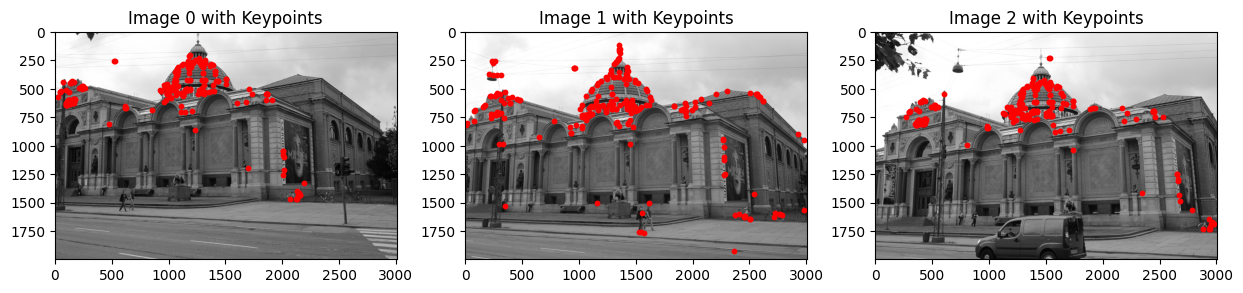

In [68]:
#part 11.3

'''Use matches01 and matches12 and find the subset of matches such that we can match features all the way from image 0 to image 2. 
In other words, create three lists such that points0[i], points1[i], and points2[i] are the 2D locations of the same point in the corresponding images.
'''

#this finds common keypoints in image 1 between images 0 and 2
_, idx01, idx12 = np.intersect1d(new_matches_01[:,1], new_matches_12[:,0], return_indices=True)

print(idx01)
print(idx12)

points0_matched = []
points1_matched = []
points2_matched = []

# Iterate over the common keypoints
for i in range(len(idx01)):
    # Get the indices of the common keypoints in matches01 and matches12
    idx_01 = new_matches_01[idx01[i], 0]  # Index of the common keypoint in matches01
    idx_12 = new_matches_01[idx01[i], 1]  # Index of the common keypoint in matches12
    
    # Append the keypoints to the respective lists
    points0_matched.append(kp0[idx_01])
    points1_matched.append(kp1[idx_01])
    points2_matched.append(kp2[new_matches_12[idx12[i], 1]])



# Convert the lists to numpy arrays
points0_matched = np.array(points0_matched)
points1_matched = np.array(points1_matched)
points2_matched = np.array(points2_matched)

# Plot the keypoints on images 0, 1, and 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot image 0 with keypoints
axes[0].imshow(cv2.cvtColor(im0, cv2.COLOR_BGR2RGB))
axes[0].scatter(points0_matched[:, 0], points0_matched[:, 1], c='r', s=10)
axes[0].set_title('Image 0 with Keypoints')

# Plot image 1 with keypoints
axes[1].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
axes[1].scatter(points1_matched[:, 0], points1_matched[:, 1], c='r', s=10)
axes[1].set_title('Image 1 with Keypoints')

# Plot image 2 with keypoints
axes[2].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
axes[2].scatter(points2_matched[:, 0], points2_matched[:, 1], c='r', s=10)
axes[2].set_title('Image 2 with Keypoints')

plt.show()


In [70]:
#part 11.4
#For the points that have been tracked through all three images, 
#use the 2D positions in image 0 and 1 to triangulate the points in 3D (Q)
from util_functions import pi


In [84]:
points0_matched_homo = (pi(points0_matched.T)).T
points1_matched_homo = (pi(points1_matched.T)).T
#i already have E_01
#already have R and t, but recalculate them with the points that actually match





(array([[ 0.11248934,  0.68468047,  0.13030367],
       [ 0.63326511, -0.15815399,  0.26002775],
       [ 0.07830141,  0.02083094,  0.03691763]]), array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
 

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'recoverPose'
> Overload resolution failed:
>  - recoverPose() missing required argument 'distCoeffs1' (pos 4)
>  - recoverPose() missing required argument 'distCoeffs1' (pos 4)
>  - E is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'E'
>  - 'cameraMatrix' is an invalid keyword argument for recoverPose()
>  - 'cameraMatrix' is an invalid keyword argument for recoverPose()
>  - recoverPose() missing required argument 'distanceThresh' (pos 5)
>  - recoverPose() missing required argument 'distanceThresh' (pos 5)
